### Power Series notebook description ###

The purpose of this ML exercise is to model and predict a Site’s exported power within a
specific time window. For instance, having chosen a time window of 1 hour, your outcomes
should represent the hourly power (the choice of time window is up to you). In addition to
predictive modeling, you are encouraged to report possible variable interactions or correlations
you may discover through your analysis.

#### Overview: ####

    * Sanitize the input data.
    * Visualize the input data and spot outliers the the characteristics of the dataset.
    * Clean the dataset.
    * Actual prediction on the timeseries.
    * Show metrics and if the regressor is overfitting.
    * Show best/worst cases.    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from xgboost import plot_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv("dataset/power_dataset.csv", sep=";")
print("Dataframe shape :", df.shape)

Dataframe shape : (14592, 5)


In [3]:
df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x : [float(str(i).replace(",",".")) for i in x ]) # change everything apart from the first column
df[df.columns[1:]] = df[df.columns[1:]].replace("nan", np.nan)

In [4]:
df.head() # The change from , to . will make the calculations later on much easier.

,Timestamp,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
0,2019-01-01 00:15:00,0.0,0.0,14.43,145991.8
1,2019-01-01 00:30:00,0.0,0.0,14.35,145991.8
2,2019-01-01 00:45:00,0.0,0.0,14.66,145991.8
3,2019-01-01 01:00:00,0.0,0.0,14.54,145991.8
4,2019-01-01 01:15:00,0.0,0.0,13.79,145991.8


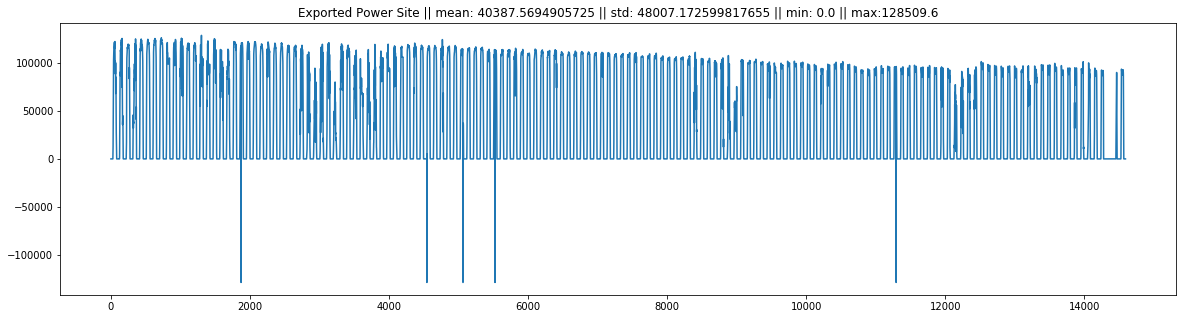

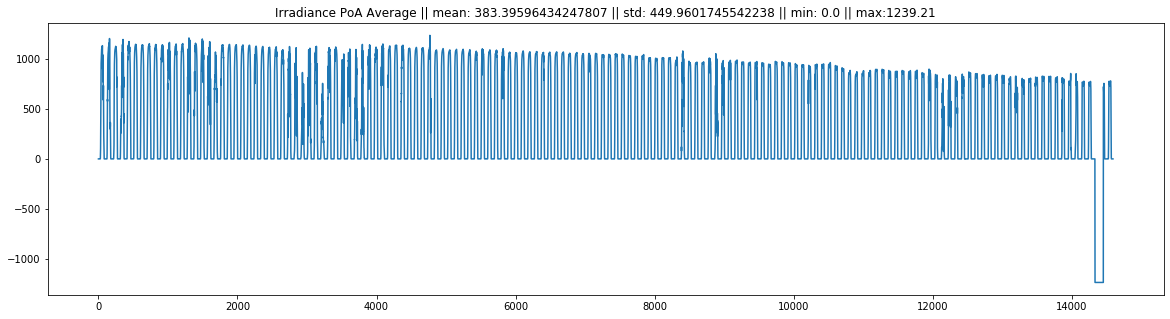

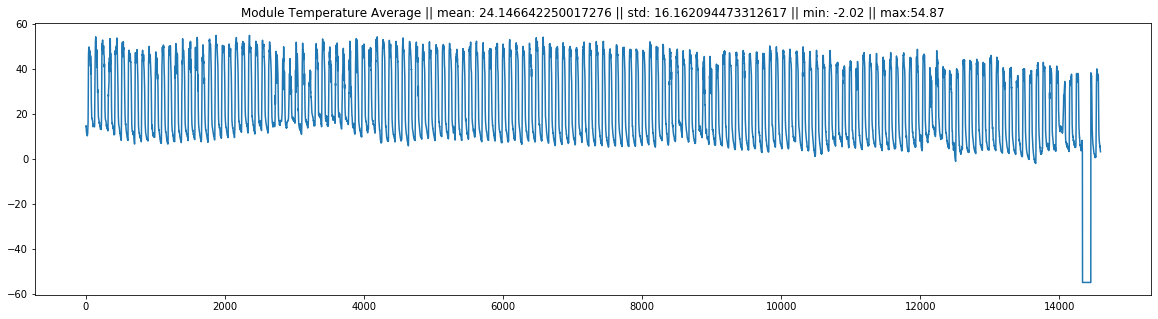

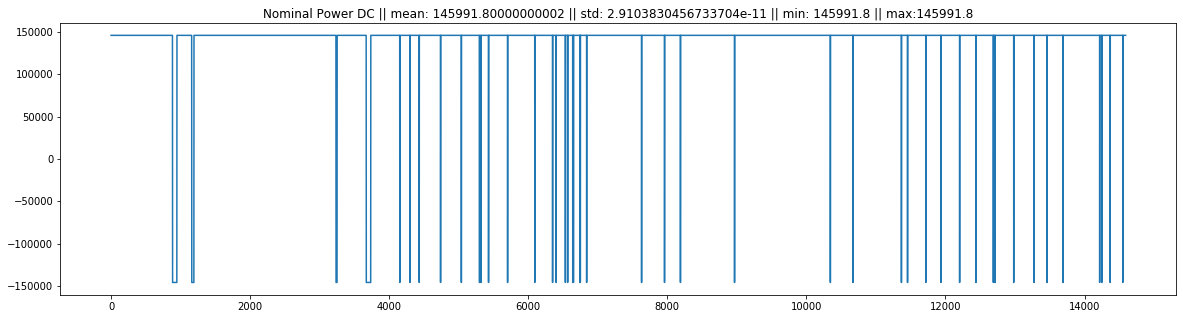

In [5]:
cols = df.columns[1:]
twin_df = df.copy()
twin_df[cols] = twin_df[cols].astype(float)
df_info = {i:"" for i in cols}
for i in cols:
    std = np.std(df[i]) # i don't use twin_df here in order not to mess with the calculations
    mn = np.mean(df[i])
    minimum = np.min(df[i])
    maximum = np.max(df[i])
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    twin_df[i] = twin_df[i].fillna(nan_indicating_value)
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(twin_df[i]) # in order to check the actual values that would be nan otherwise.
    plt.show()

Indicate the NaN values as a large negative number, since the values we posses can't be negative (apart from the temperature).

In [6]:
pd.DataFrame.from_dict(df_info)

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
mean,40387.569491,383.395964,24.146642,1.459918e+05
std,48007.172600,449.960175,16.162094,2.910383e-11
min,0.000000,0.000000,-2.020000,1.459918e+05
max,128509.600000,1239.210000,54.870000,1.459918e+05


Just by noticing the plots it is straightforward that Irradiance and temperature average are highly correlated with each other (it makes sense since they are both affected by the same enviromental variables). 

Also obvious from the plots that apart from the NaN values there aren't any outliers in our dataset.

In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.index = df['Timestamp']
del df["Timestamp"]
df = df.astype(float)
df = df.resample('3600s').mean() # Select timeslot. for now i select 3600 sec aka 60 min
df.head()
# The actual resampling should be considered a hyperparameter.
# Changing it's value tends to change the results slightly

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-01 00:00:00,0.0,0.0,14.4800,145991.8
2019-01-01 01:00:00,0.0,0.0,13.4225,145991.8
2019-01-01 02:00:00,0.0,0.0,11.6750,145991.8
2019-01-01 03:00:00,0.0,0.0,11.2725,145991.8
2019-01-01 04:00:00,0.0,0.0,10.5250,145991.8


In [8]:
df["Nominal Power DC"].unique() # this feature seems that it cannot actually offer new information 

array([145991.8,      nan])

There are several ways to tackle the NaN issue 

1. Interpolation.
2. Mean averaging the neighbors (since we have very few nan samples compared to our actual dataset)
3. Eliminate the rows that contain these values since they don't provide actual information about our dataset

In our case the latter is the obvious solution, since interpolation contains high risk when outliers are possible.

In [9]:
print("NaNs ration in nominal power",len(df[df["Nominal Power DC"].isnull()])/len(df["Nominal Power DC"]))

NaNs ration in nominal power 0.011510002740476843


"Nominal Power DC" has no statistical significance especially since it's either a constant or a nan value.

(You can easily add that feature and try to run the model but it will produce slightly worse results)

In [10]:
df[df["Nominal Power DC"].isnull()].head()

,Exported Power Site,Irradiance PoA Average,Module Temperature Average,Nominal Power DC
Timestamp,,,,
2019-01-10 06:00:00,0.0000,0.0000,8.2875,NaN
2019-01-10 07:00:00,4368.5550,52.4150,8.5125,NaN
2019-01-10 08:00:00,56902.6825,530.1000,23.5225,NaN
2019-01-10 09:00:00,109225.9900,914.5600,40.5750,NaN
2019-01-10 10:00:00,116388.6900,1035.2425,46.6825,NaN


Amongst these features we could've added the feature of season aka winter, summer.
Which would be straightforward (Even though the majority of the timestamps belong to spring)

In [11]:
(df[df["Module Temperature Average"].isnull()]["Exported Power Site"]).unique()
# Which means that when we have NaN values.
# On the Module Temperature Average the site doesn't produce energy at all.

array([0.])

In [12]:
f_cols = list(set(df.columns) - set(["Nominal Power DC"]))
print("the collumns to be used are :",", ".join(f_cols))
final_df = df[f_cols].copy()

the collumns to be used are : Irradiance PoA Average, Module Temperature Average, Exported Power Site


In [13]:
final_df.tail()

,Irradiance PoA Average,Module Temperature Average,Exported Power Site
Timestamp,,,
2019-06-01 20:00:00,0.0,7.14,0.0
2019-06-01 21:00:00,0.0,5.77,0.0
2019-06-01 22:00:00,0.0,5.25,0.0
2019-06-01 23:00:00,0.0,3.78,0.0
2019-06-02 00:00:00,0.0,3.18,0.0


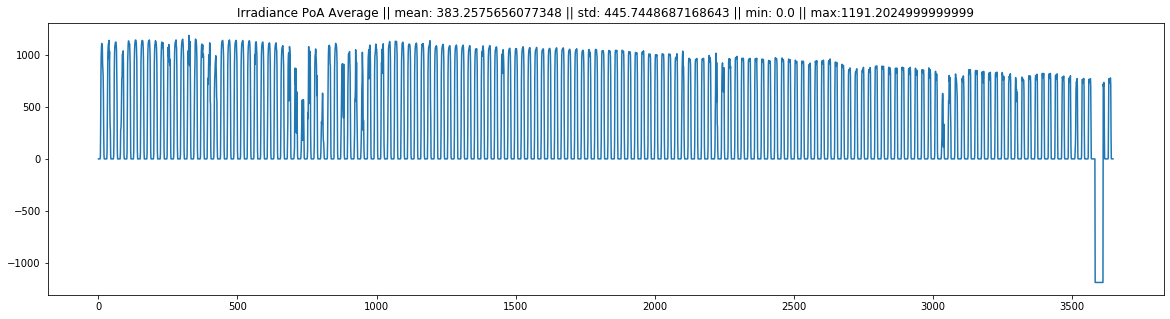

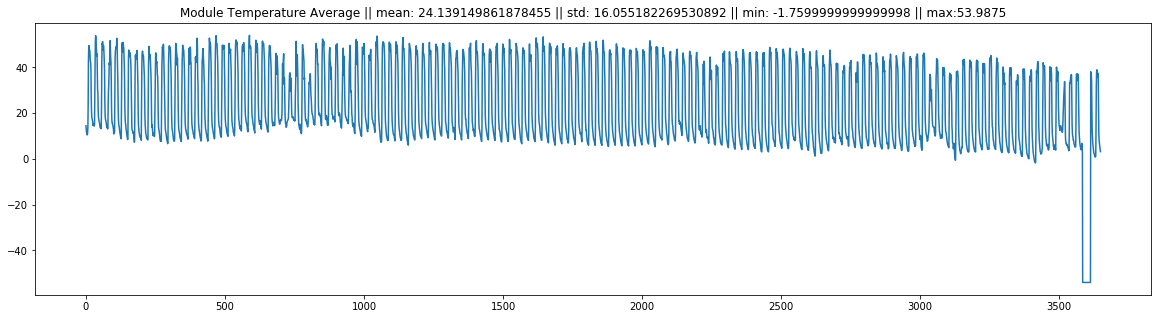

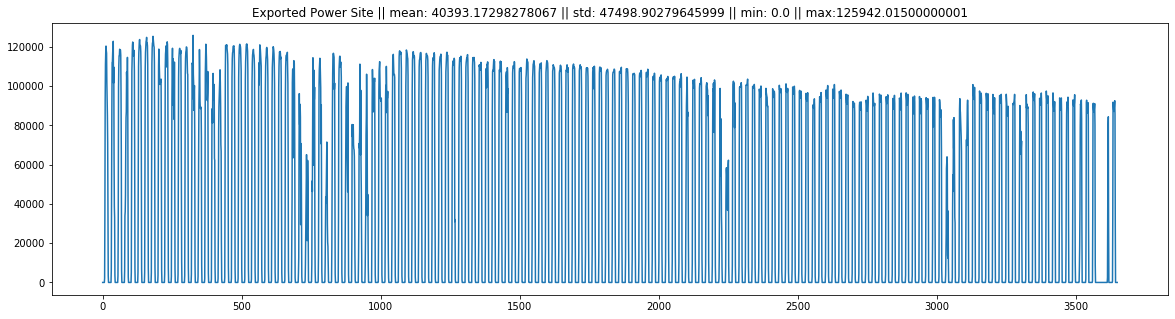

In [14]:
for i in f_cols:
    std = np.std(final_df[i])  # I don't use twin_df here in order not to mess with the calculations.
    mn = np.mean(final_df[i])
    minimum = np.min(final_df[i])
    maximum = np.max(final_df[i])
    text = "|| mean: {} || std: {} || min: {} || max:{}".format(mn, std, minimum, maximum)
    
    nan_indicating_value = - np.max(np.abs(df[i].astype(float)))
    
    df_info[i] = {"mean":mn, "std":std, "min":minimum, "max":maximum}
    plt.figure(figsize=(20,5))
    plt.title(i+" "+text)
    plt.plot(final_df[i].fillna(nan_indicating_value).values) # in order to check the actual values that would be nan otherwise.
    plt.show()

In [15]:
final_df[final_df["Exported Power Site"].isnull()]

,Irradiance PoA Average,Module Temperature Average,Exported Power Site
Timestamp,,,


changing the nan value of exported Power Site to 0 should be correct since this value has to be a positive integer

In [16]:
final_df["Exported Power Site"].fillna(0, inplace=True)

In [17]:
final_df = final_df.dropna() # Actually drop the nan values since we can't make an inference out of them

In [18]:
final_df.isnull().any()

Irradiance PoA Average        False
Module Temperature Average    False
Exported Power Site           False
dtype: bool

In [19]:
final_df[f_cols] = final_df[f_cols].astype(float)

In [20]:
final_df.head()

,Irradiance PoA Average,Module Temperature Average,Exported Power Site
Timestamp,,,
2019-01-01 00:00:00,0.0,14.4800,0.0
2019-01-01 01:00:00,0.0,13.4225,0.0
2019-01-01 02:00:00,0.0,11.6750,0.0
2019-01-01 03:00:00,0.0,11.2725,0.0
2019-01-01 04:00:00,0.0,10.5250,0.0


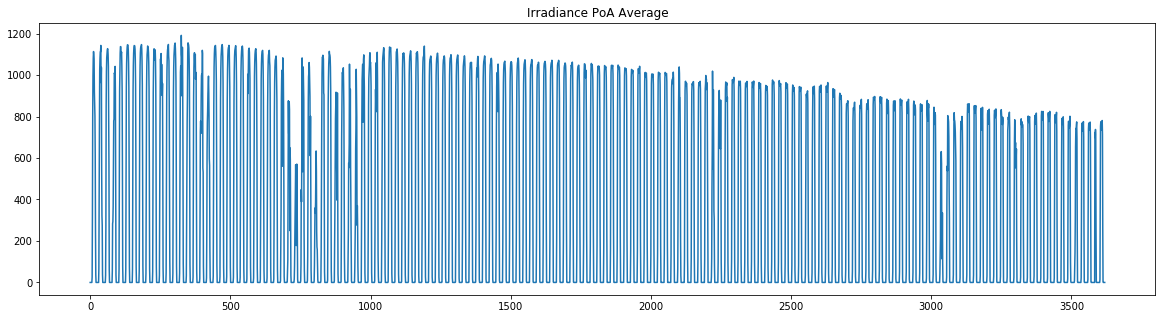

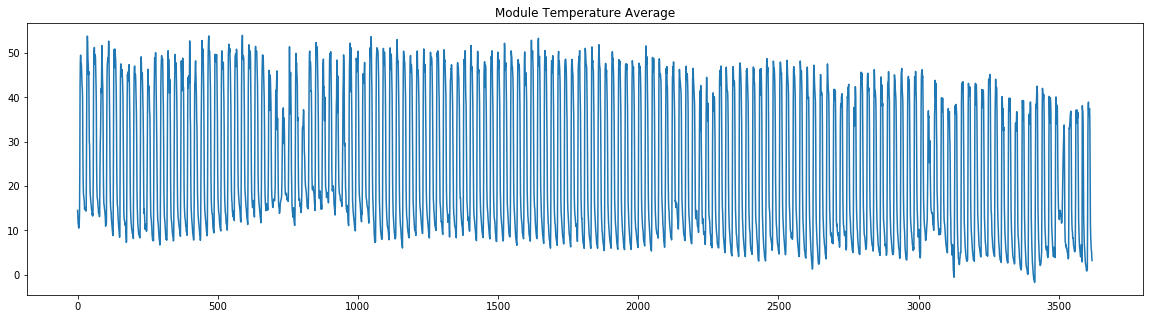

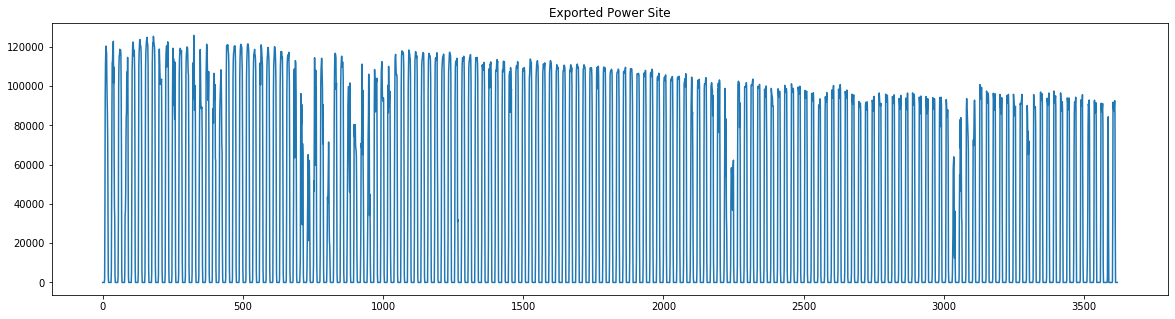

In [21]:
for i in f_cols:
    plt.figure(figsize=(20,5))
    plt.title(i)
    plt.plot(final_df[i].values) # in order to check the actual values that would be nan otherwise.
    plt.show()

In most machine learning problems we split the datasets into train and validation sets for tuning as well as test in order to check the inference of our model. in this problem the data that we possesed are not enough for this kind of split, instead i decided to split the dataset 70% - 30% as train and validation.

In [22]:
split_index = (7 * final_df.shape[0])//10 # I am going to split the dataset 70% train 30% validation

In [23]:
print(final_df.index.to_list()[split_index])
label = "Exported Power Site"

2019-04-16 14:00:00


In [24]:
def clear_sets(X_all, label):
    Y_series_train = X_all[label]
    del X_all[label]
    X_series_train = X_all
    return X_series_train, Y_series_train

Actually rescale data in order not to punish the data that contain significantly lower values.

In [25]:
final_df = (final_df - final_df.mean())/final_df.std()

In [26]:
series_train = final_df.loc[final_df.index <= final_df.index.to_list()[split_index]].copy()
X_series_train, Y_series_train = clear_sets(series_train, label)

In [27]:
series_test = final_df.loc[final_df.index > final_df.index.to_list()[split_index]].copy()
X_series_test, Y_series_test = clear_sets(series_test, label)

In [28]:
print("X, Y ", [i.shape for i in (X_series_train, Y_series_train)])
print("X, Y ", [i.shape for i in (X_series_test, Y_series_test)])

X, Y  [(2535, 2), (2535,)]
X, Y  [(1085, 2), (1085,)]


In [29]:
reg = xgb.XGBRegressor(n_estimators=1000) #since our data are not many we use high number of estimators

In [30]:
eval_metric = ["mae", "error"]
reg.fit(X_series_train, Y_series_train,
        eval_set=[(X_series_train, Y_series_train), (X_series_test, Y_series_test)],
        eval_metric=eval_metric,
        early_stopping_rounds=50,
       verbose=False)

[01:23:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dimitrisl/miniconda3/envs/timeseries/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

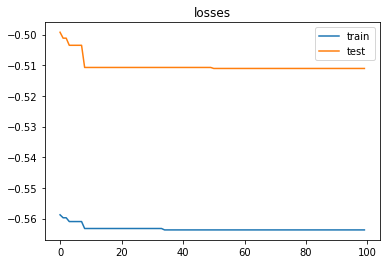

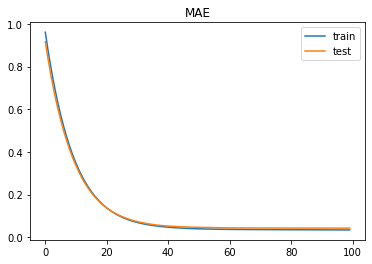

In [31]:
results = reg.evals_result()

plt.title("losses")
plt.plot(results['validation_0']["error"], label="train")
plt.plot(results["validation_1"]["error"], label="test")
plt.legend()
plt.show()

plt.title("MAE")
plt.plot(results['validation_0']["mae"], label="train")
plt.plot(results["validation_1"]["mae"], label="test")
plt.legend()
plt.show()

In [32]:
# The regressor is clearly NOT overfitting since we can see that the loss curves are parallelised.

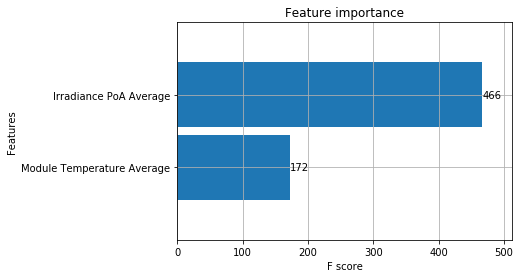

In [33]:
_ = plot_importance(reg, height=0.9)

In [34]:
y_test_predictions = reg.predict(X_series_test)
y_train_predictions = reg.predict(X_series_train)

r2 test score:  0.9876541777981


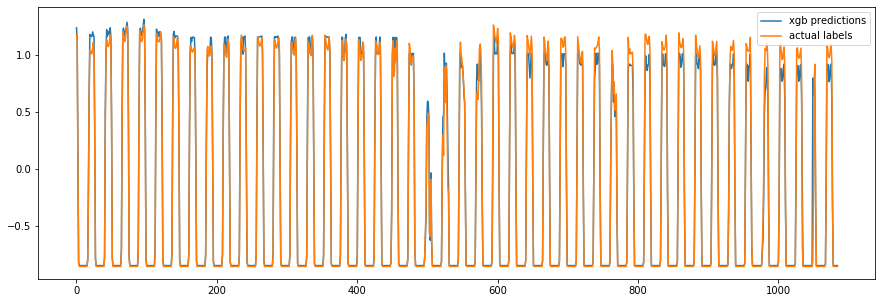

r2 train score:  0.9931656370944454 train


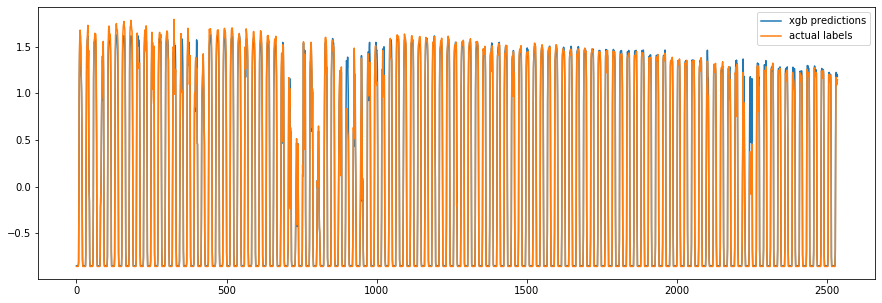

In [35]:
print("r2 test score: ", r2_score(y_test_predictions, Y_series_test.values))
plt.figure(figsize=(15,5))
plt.plot(y_test_predictions, label="xgb predictions")
plt.plot(Y_series_test.values, label="actual labels")
plt.legend(loc='upper right')
plt.show()

print("r2 train score: ",r2_score(y_train_predictions, Y_series_train.values),"train")
plt.figure(figsize=(15,5))
plt.plot(y_train_predictions, label="xgb predictions")
plt.plot(Y_series_train.values, label="actual labels")
plt.legend(loc='upper right')
plt.show()

We can see that the actual labels follow the flow of the xgb predictions

In [36]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [37]:
print("mean absolute error: ")
print(mean_absolute_error(y_test_predictions, Y_series_test.values))
print("mean squared error: ")
print(mean_squared_error(y_test_predictions, Y_series_test.values))

mean absolute error: 
0.046006614264852794
mean squared error: 
0.008885181660424759


In [38]:
MAE_results = np.abs(Y_series_test - y_test_predictions)

In [39]:
print("Datetime with the highest prediction error: ")
MAE_results[MAE_results==MAE_results.max()].index[0]
print("Max Error ", MAE_results.max())

Datetime with the highest prediction error: 
Max Error  1.601710867945683


In [40]:
top_mae = MAE_results.sort_values(ascending=False)

Datetimes with worst predictions

In [41]:
top_mae.head(20)

Timestamp
2019-05-31 13:00:00    1.601711
2019-05-31 14:00:00    0.775591
2019-05-29 17:00:00    0.479033
2019-05-27 12:00:00    0.378189
2019-05-08 10:00:00    0.346195
2019-05-08 16:00:00    0.333144
2019-05-27 13:00:00    0.320867
2019-05-27 11:00:00    0.311694
2019-06-01 16:00:00    0.303575
2019-05-20 09:00:00    0.301866
2019-05-28 09:00:00    0.301029
2019-05-31 16:00:00    0.297336
2019-05-27 16:00:00    0.286594
2019-05-11 09:00:00    0.282453
2019-05-20 11:00:00    0.271513
2019-05-17 09:00:00    0.268414
2019-05-19 09:00:00    0.267747
2019-05-28 16:00:00    0.265675
2019-05-26 12:00:00    0.263332
2019-05-20 16:00:00    0.261593
Name: Exported Power Site, dtype: float64

Datetimes with best predictions

In [42]:
top_mae.tail(20)

Timestamp
2019-05-26 07:00:00    0.003163
2019-04-29 09:00:00    0.003157
2019-04-24 17:00:00    0.003126
2019-05-26 18:00:00    0.003114
2019-05-11 18:00:00    0.003077
2019-05-14 11:00:00    0.003021
2019-05-04 18:00:00    0.002876
2019-05-16 17:00:00    0.002645
2019-04-17 07:00:00    0.002488
2019-05-21 07:00:00    0.002342
2019-05-25 07:00:00    0.002126
2019-05-01 17:00:00    0.002048
2019-05-23 17:00:00    0.001584
2019-05-07 14:00:00    0.001067
2019-05-12 10:00:00    0.001052
2019-05-05 07:00:00    0.001032
2019-04-19 09:00:00    0.000826
2019-05-27 07:00:00    0.000656
2019-05-03 15:00:00    0.000621
2019-05-09 14:00:00    0.000240
Name: Exported Power Site, dtype: float64

In [43]:
top_mae.mean()

0.04600661426485279